# Fonctions initiales

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LinearRegression

In [3]:
data=pd.read_csv("/Users/louisperdriel/Documents/troisieme_cycle/\
Cursus/ADD2/Examen/Suicide dataset notebook/suicide_rate.csv",sep=",")

data=pd.read_csv("suicide_rate.csv",sep=",")

data=data.drop(["HDI for year", "country-year", "generation"], axis=1 )
data.rename(columns={"suicides/100k pop": "scd_r"}, inplace=True)
data.rename(columns={" gdp_for_year ($) ": "gdp_yr"}, inplace=True)
data["gdp_yr"]=data["gdp_yr"].str.replace(",","")
data["gdp_yr"] = pd.to_numeric(data["gdp_yr"])
data.rename(columns={"gdp_per_capita ($)": "gdp_cp"}, inplace=True)

df = data[["year", "sex","age", "scd_r", "gdp_yr", "gdp_cp"]]

# 1) Analyses descriptives traditionnelles

In [168]:
df.shape

(27820, 6)

In [169]:
df.head()

,year,sex,age,scd_r,gdp_yr,gdp_cp
0,1987,male,15-24 years,6.71,2156624900,796
1,1987,male,35-54 years,5.19,2156624900,796
2,1987,female,15-24 years,4.83,2156624900,796
3,1987,male,75+ years,4.59,2156624900,796
4,1987,male,25-34 years,3.28,2156624900,796


In [170]:
df.describe()

,year,scd_r,gdp_yr,gdp_cp
count,27820.000000,27820.000000,2.782000e+04,27820.000000
mean,2001.258375,12.816097,4.455810e+11,16866.464414
std,8.469055,18.961511,1.453610e+12,18887.576472
min,1985.000000,0.000000,4.691962e+07,251.000000
25%,1995.000000,0.920000,8.985353e+09,3447.000000
50%,2002.000000,5.990000,4.811469e+10,9372.000000
75%,2008.000000,16.620000,2.602024e+11,24874.000000
max,2016.000000,224.970000,1.812071e+13,126352.000000


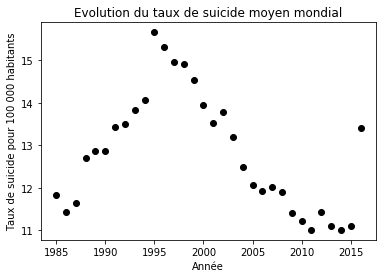

In [4]:
s_yr = df.groupby('year')["scd_r"].mean()
fig=plt.figure()
plt.plot(s_yr.keys(), list(s_yr), 'o', color='black')
plt.title("Evolution du taux de suicide moyen mondial")
plt.xlabel("Année")
plt.ylabel("Taux de suicide pour 100 000 habitants");
fig.savefig("suicide_evol.png")

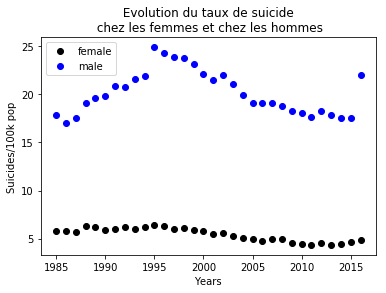

In [5]:
s_yr_sex = df.pivot_table('scd_r', index='sex', columns='year')
fig=plt.figure()
plt.plot(s_yr_sex.keys(), s_yr_sex.loc["female"], 'o', color='black')
plt.plot(s_yr_sex.keys(), s_yr_sex.loc["male"], 'o', color='blue')
plt.title(" Evolution du taux de suicide \n chez les femmes et chez les hommes")
plt.xlabel("Years")
plt.ylabel("Suicides/100k pop")
plt.legend();
fig.savefig("suicide_evol_sex.png")

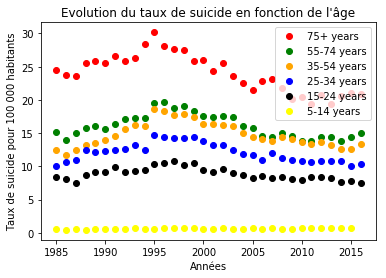

In [6]:
s_yr_age = df.pivot_table('scd_r', index='age', columns='year')
fig= plt.figure()

plt.plot(s_yr_age.keys(), s_yr_age.iloc[5], 'o', color='red')
plt.plot(s_yr_age.keys(), s_yr_age.iloc[4], 'o', color='green')
plt.plot(s_yr_age.keys(), s_yr_age.iloc[2], 'o', color='orange')
plt.plot(s_yr_age.keys(), s_yr_age.iloc[1], 'o', color='blue')
plt.plot(s_yr_age.keys(), s_yr_age.iloc[0], 'o', color='black')
plt.plot(s_yr_age.keys(), s_yr_age.iloc[3], 'o', color='yellow')

plt.title("Evolution du taux de suicide en fonction de l'âge")
plt.xlabel("Années")
plt.ylabel("Taux de suicide pour 100 000 habitants")
plt.legend(prop={'size': 10});

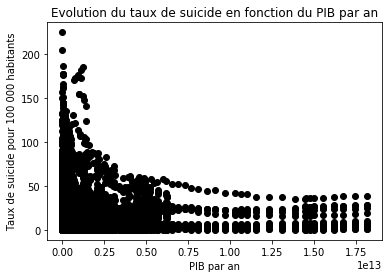

In [7]:
fig=plt.figure()
plt.plot(df["gdp_yr"], df["scd_r"], 'o', color="black")
plt.title("Evolution du taux de suicide en fonction du PIB par an")
plt.xlabel("PIB par an")
plt.ylabel("Taux de suicide pour 100 000 habitants");
fig.savefig("suicide_r_pib_yr.png")

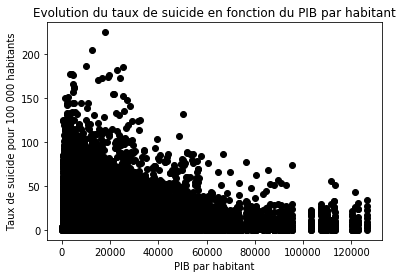

In [8]:
fig=plt.figure()
plt.plot(df["gdp_cp"], df["scd_r"], 'o', color="black")
plt.title("Evolution du taux de suicide en fonction du PIB par habitant")
plt.xlabel("PIB par habitant")
plt.ylabel("Taux de suicide pour 100 000 habitants");
fig.savefig("suicide_r_pib_cp.png")

# 2) Clustering non supervisé

Définitions des fonctions que nous utiliserons par la suite

In [9]:
def pca_improved (df, k):
    arr_dict = df.to_dict(orient="records") 
    vec = DictVectorizer(sparse=False, dtype=int)
    arr_vect = vec.fit_transform(arr_dict)
    ss=StandardScaler()
    arr_scaled = ss.fit_transform(arr_vect)
    pca=PCA(k,random_state=26)
    arr_pca = pca.fit_transform(arr_scaled)
    return vec, pca, arr_pca

def result_pca (k, pca_singular_values_, pca_explained_variance_ratio_, pca_explained_variance_ratio_cumsum):
    eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(k)], 
        "Valeur propre" : pca_singular_values_,
        "Pourcentage de variance expliquée" : np.round(pca_explained_variance_ratio_ * 100),
        "Pourcentage cumulé de variance expliquée" : np.round(pca_explained_variance_ratio_cumsum * 100)
    },
    columns = ["Dimension", "Valeur propre", "Pourcentage de variance expliquée", "Pourcentage cumulé de variance expliquée"]
    )
    return eig

def prep_circleOfCorrelation(pca_components_, pca_explained_variance_ratio_, vec_feature_names_ ):
    coef=np.transpose(pca_components_)
    ebouli=pd.Series(pca.explained_variance_ratio_)
    cols=["PC-"+str(x) for x in range(len(ebouli))]
    pc_infos=pd.DataFrame(coef,columns=cols,index=vec_feature_names_)
    return pc_infos, ebouli

def circleOfCorrelations(pc_infos, ebouli):
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x,y))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")
    plt.show()
    fig.savefig('circleOfCorrelation.png')
    
def pca_plot (arr_pca):
    fig = plt.figure()
    plt.plot(arr_pca[:,0],arr_pca[:,1], 'ro', alpha = 0.1)
    plt.xlabel("PC-1")
    plt.ylabel("PC-2")
    plt.plot([-5,5],[0,0],'k--')
    plt.plot([0,0],[-5,5],'k--')
    plt.title("Projection en deux dimensions de toutes les observations du data set")
    plt.show()
    fig.savefig("repres_donnee.png")

# Première analyse

Analysons tout d'abord le data set dans son intégralité.

In [10]:
df_c=df.copy()
k=10
_,pca, arr_pca = pca_improved(df_c,k)
result_pca (k, pca.singular_values_, pca.explained_variance_ratio_, pca.explained_variance_ratio_.cumsum())

#title = "resultat_apc_df_all_variable.csv"
#eig.to_csv(title, sep = ";")


/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Dimension,Valeur propre,Pourcentage de variance expliquée,Pourcentage cumulé de variance expliquée
0,Dim1,251.540369,19.0,19.0
1,Dim2,204.593320,13.0,31.0
2,Dim3,196.574247,12.0,43.0
3,Dim4,182.733910,10.0,53.0
4,Dim5,182.733910,10.0,63.0
5,Dim6,182.733910,10.0,73.0
6,Dim7,182.689821,10.0,83.0
7,Dim8,159.030595,8.0,91.0
8,Dim9,128.201296,5.0,96.0
9,Dim10,121.616869,4.0,100.0


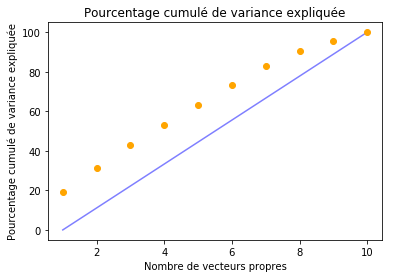

In [11]:
x = np.linspace(1, k, k)
y_base = np.linspace(0, 100, k)
y_1 = pca.explained_variance_ratio_.cumsum()*100

plt.plot(x, y_base, alpha=0.5, color = "blue")
plt.plot(x, y_1, "o",color="orange" )
plt.title("Pourcentage cumulé de variance expliquée")
plt.xlabel("Nombre de vecteurs propres")
plt.ylabel("Pourcentage cumulé de variance expliquée");

#plt.savefig('resultat_apc_df_all_variable.png')

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


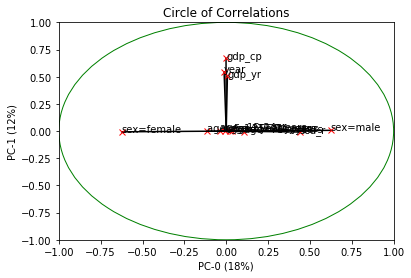

In [12]:
k=2
vec,pca, arr_pca = pca_improved(df_c,k)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_, vec.feature_names_ )
circleOfCorrelations(pc_infos, ebouli)

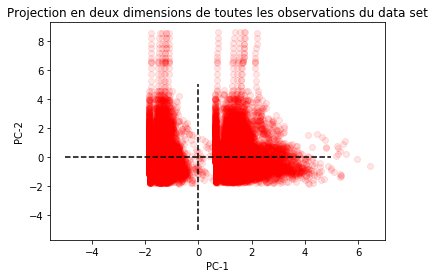

In [180]:
pca_plot(arr_pca)

# Analyses exploratoires

Du fait de la superposition des valeurs dans le cercle de corrélation on ne comprend pas très bien comment lire la représentation graphique du data_set réduit pour k=2. 
Afin de mieux comprendre cette représentation, nous vous proposons ci-après de représenter le data set simplifié en ne retenant que certaintes valeurs

## Variables retenues : Taux de suicide, année, PIB par année et PIB par habitant

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


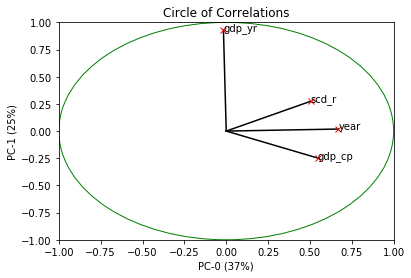

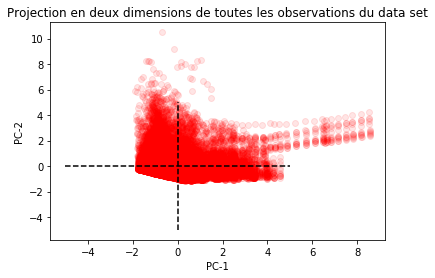

(None, None)

In [13]:
df1=df.copy()
df1 = df1.drop(["sex", "age"], axis=1)
_,pca, arr_pca = pca_improved(df1,2)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_, df1.columns)
circleOfCorrelations(pc_infos, ebouli), pca_plot(arr_pca)

## Variables retenues : Taux de suicide, Sexe, Catégorie d’âge, Année

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


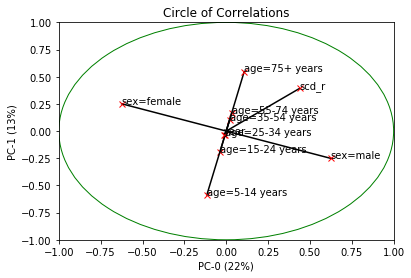

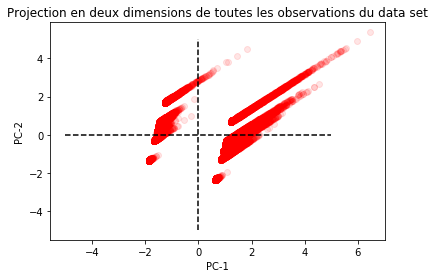

(None, None)

In [14]:
df3=df.copy()
df3 = df3.drop(["gdp_yr", "gdp_cp"], axis=1)
vec,pca, arr_pca = pca_improved(df3,2)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_,\
                                            vec.feature_names_ )
circleOfCorrelations(pc_infos, ebouli), pca_plot(arr_pca)

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


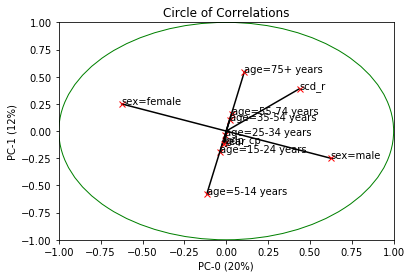

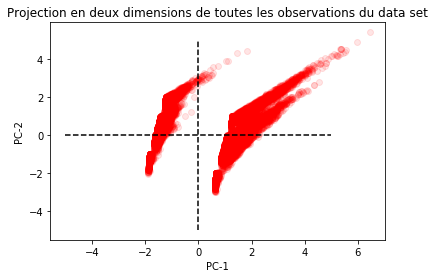

(None, None)

In [183]:
df4=df.copy()
df4 = df4.drop(["gdp_yr"], axis=1)
vec, pca, arr_pca = pca_improved(df4,2)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_,\
                                            vec.feature_names_ )
circleOfCorrelations(pc_infos, ebouli), pca_plot(arr_pca)

## Variables retenues : Taux de suicide, Sexe, Catégorie d’âge, Année, PIB par année

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


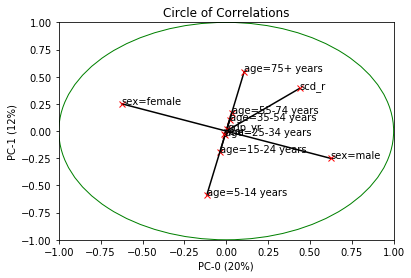

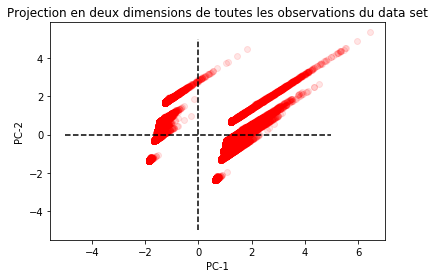

(None, None)

In [15]:
df5=df.copy()
df5 = df5.drop(["gdp_cp"], axis=1)
vec, pca, arr_pca = pca_improved(df5,2)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_,\
                                            vec.feature_names_ )
circleOfCorrelations(pc_infos, ebouli), pca_plot(arr_pca)

## Variables retenues : Taux de suicide, Sexe, Catégorie d’âge, Année, PIB par année, PIB par habitant (Suppression de la variable Sexe)

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


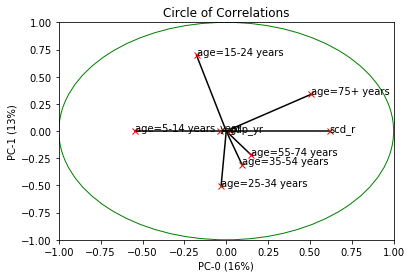

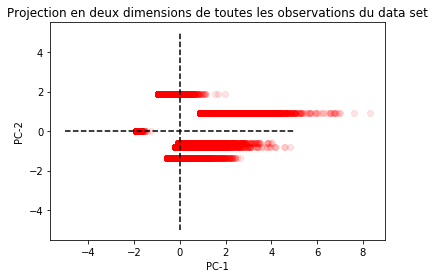

(None, None)

In [16]:
df7=df.copy()
df7 = df5.drop(["sex"], axis=1)
vec, pca, arr_pca = pca_improved(df7,2)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_,\
                                            vec.feature_names_ )
circleOfCorrelations(pc_infos, ebouli), pca_plot(arr_pca)

## K-Means

Reprenons maintenant notre base de donnée initiale: 

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


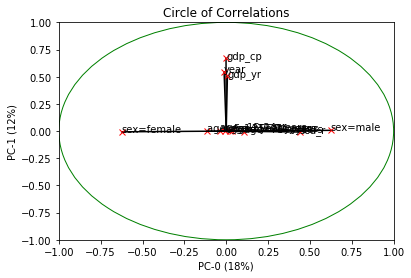

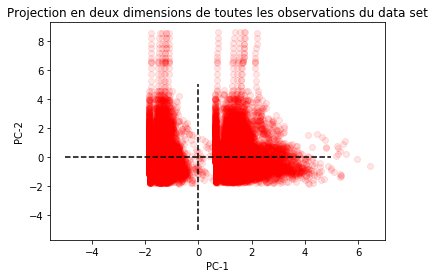

(None, None)

In [17]:
vec, pca, arr_pca = pca_improved(df_c,2)
pc_infos, ebouli = prep_circleOfCorrelation(pca.components_, pca.explained_variance_ratio_,\
                                            vec.feature_names_ )
circleOfCorrelations(pc_infos, ebouli), pca_plot(arr_pca)

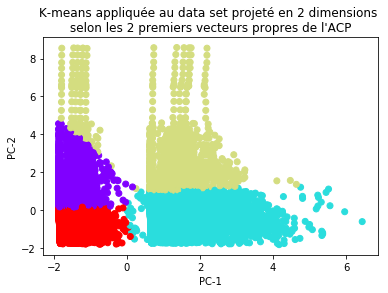

In [25]:
kmeans = MiniBatchKMeans(4)
kmeans.fit(arr_pca)
fig=plt.figure()
plt.scatter(arr_pca[:,0],arr_pca[:,1],c=kmeans.fit_predict(arr_pca),cmap="rainbow")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.title("K-means appliquée au data set projeté en 2 dimensions \n selon les 2 premiers vecteurs propres de l'ACP ")
fig.savefig("k-means.png")

# 3) Regression linéaire

In [20]:
def df_clean (data):
    arr_dict = data.to_dict(orient="records") 
    vec = DictVectorizer(sparse=False, dtype=int)
    arr_vect = vec.fit_transform(arr_dict)
    df_scaled = pd.DataFrame (data=arr_vect[0:,0:], columns=vec.feature_names_)
    return df_scaled

Coefficient de déterminantion R^2: 0.5144804464214191


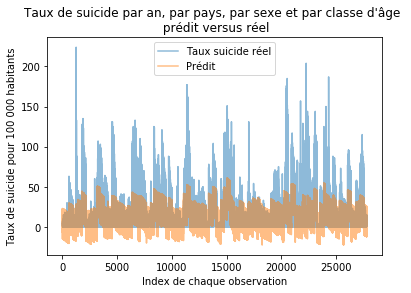

In [21]:
df_0=df.copy()
df_0["country"]=data["country"]
df_0=df_clean(df_0)

X = df_0.drop(["scd_r"], axis=1)
y = df_0["scd_r"] 

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
params = pd.Series(model.coef_, index=X.columns)
df_0['predicted'] = model.predict(X)
print("Coefficient de déterminantion R^2: "+str(model.score(X,y)))
fig=plt.figure()
plt.plot(df_0.index, df_0["scd_r"] , alpha=0.5, label="Taux suicide réel")
plt.plot(df_0.index, df_0["predicted"], alpha=0.5, label="Prédit")
plt.title("Taux de suicide par an, par pays, par sexe et par classe d'âge \n prédit versus réel")
plt.xlabel("Index de chaque observation")
plt.ylabel("Taux de suicide pour 100 000 habitants")
plt.legend();
fig.savefig("tx_suicide_predit.png")

In [22]:
def mean_scd_r(x):
    x['ctr_yr_scd_r']=np.average(x['scd_r'], weights=x['population'])
    return x

Coefficient de déterminantion R^2: 0.8749181647195676


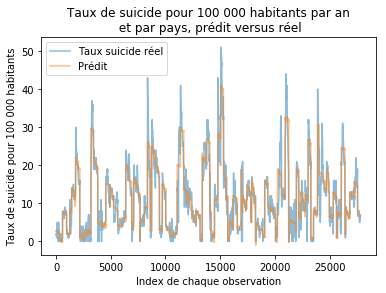

In [23]:
df_2=data.copy()
df_2=df_2.groupby(["country", "year"]).apply(mean_scd_r)
df_2=df_2.drop(["scd_r", "suicides_no"], axis=1)
df_2=df_clean(df_2)

X = df_2.drop(["ctr_yr_scd_r"], axis=1)
y = df_2["ctr_yr_scd_r"] 

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
params = pd.Series(model.coef_, index=X.columns)
df_2['predicted'] = model.predict(X)
print("Coefficient de déterminantion R^2: "+str(model.score(X,y)))
fig=plt.figure()
plt.plot(df_2.index, df_2["ctr_yr_scd_r"] , alpha=0.5, label="Taux suicide réel")
plt.plot(df_2.index, df_2["predicted"], alpha=0.5, label="Prédit")
plt.title("Taux de suicide pour 100 000 habitants par an\n et par pays, prédit versus réel")
plt.xlabel("Index de chaque observation")
plt.ylabel("Taux de suicide pour 100 000 habitants")
plt.legend();
fig.savefig("tx_suicide_predit_pr_an.png")

# Implémentation d'une technique de cross-validation + pénalisation

In [193]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [194]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=2)

In [195]:
alphas = [0.000001,0.001,0.1,0.5,5,20,50,100,500]

In [196]:
def erreur_absolue_moyenne(y_pred,y_true):
    return (np.mean(np.abs(y_pred-y_true)))

In [197]:
resultat_MAE_ridge = []

for alp in alphas:
    ridge=Ridge(alpha=alp)
    ridge.fit(X_train,y_train)
    y_pred=ridge.predict(X_train)
    resultat_MAE_ridge.append(erreur_absolue_moyenne(y_pred,y_train))

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.632115e-35
  overwrite_a=True).T
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.632113e-32
  overwrite_a=True).T
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.631884e-30
  overwrite_a=True).T
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recipr

In [198]:
resultat_MAE_lasso = []

for alp in alphas:
    lasso=Lasso(alpha=alp)
    lasso.fit(X_train,y_train)
    y_pred=lasso.predict(X_train)
    resultat_MAE_lasso.append(erreur_absolue_moyenne(y_pred,y_train))
    

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [199]:
MAE_dict = {"Coefficients Alphas":alphas,\
            "Ridge": resultat_MAE_ridge,\
            "Lasso": resultat_MAE_lasso}

MAE =pd.DataFrame(\
                 data = MAE_dict,
                 columns = MAE_dict.keys()\
                 )

MAE
#MAE.to_csv("Pénalisation.csv", sep = ";")

,Coefficients Alphas,Ridge,Lasso
0,0.000001,2.059551,2.059547
1,0.001000,2.059550,2.067083
2,0.100000,2.059588,5.708805
3,0.500000,2.060263,6.869953
4,5.000000,2.079125,6.883031
5,20.000000,2.195087,6.883078
6,50.000000,2.521004,6.883171
7,100.000000,3.084699,6.883326
8,500.000000,5.140228,6.884591


In [200]:
alpha_ridge = 0.00000001
alpha_lasso = 0.00000001

In [201]:
ridge=Ridge(alpha=alpha_ridge)
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)

lasso=Lasso(alpha=alpha_lasso)
lasso.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.631848e-37
  overwrite_a=True).T
/Users/louisperdriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [202]:
print("ridge "+str(erreur_absolue_moyenne(y_pred_ridge,y_test)))
print("lasso "+str(erreur_absolue_moyenne(y_pred_lasso,y_test)))
print("linear reg "+str(erreur_absolue_moyenne(y_pred_lr,y_test)))

ridge 2.0369014356599493
lasso 2.036901363519262
linear reg 2.1167591880794787
